In [177]:
import cv2
import numpy as np
# from PIL import Image
from matplotlib import pyplot as plt
from sklearn.manifold import SpectralEmbedding
import math
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
# for LEM implementation
import pandas as pd
from networkx import *



class Preprocessing:
    
    def __init__(self):
        pass

    # this method reads an image and preprocess it by rescaling it to 150 x 100 a applying CLAHE over the image
    def read_image(self):
        per_num = 0
        ear_pos = ['down_ear', 'front_ear', 'left_ear', 'up_ear']
        #person_num = ['000', '001', '002', '003', '004','005','006','007','008','009','010']
        images = []
        for i in range(11):
            for j in ear_pos:
                if i < 10:
                    person_num = '00'+str(i)
                elif i>=10 and i < 100:
                    person_num = '0'+str(i)
                else:
                    person_num =  str(i)
                
                images.append(cv2.resize(cv2.imread("EarImages/"+person_num+'_'+j+".jpg", cv2.IMREAD_GRAYSCALE), dsize=(100, 150), interpolation=cv2.INTER_NEAREST))

        processed_images = []
        for i in range(len(images)):
            gray = images[i]
            mean = cv2.mean(gray)[0]
            variance = np.var(gray)
            m_t = 100
            v_t = 100
            for i in range(150):
                for j in range(100):
                    beta = math.sqrt(v_t * math.pow(gray[i][j] - mean, 2) / variance)
                    if gray[i][j] > mean:
                        gray[i][j] = m_t + beta
                    else:
                        gray[i][j] = m_t - beta
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl1 = clahe.apply(gray)
            processed_images.append(cl1)
        print(processed_images[0].shape)
        return processed_images

    # in this function we are creating sw of size 50 x 50 with step size 11 so total 50 SWs
    def sub_window_creation(self, images, kernels):
        gb_all_sw = []
        label = []
        sub_win_dict = {}
        sw_no = 0
        count = -1

        for i in range(0, 100, 11):
            for j in range(0, 50, 11):
                count = count +1
                for k in range(len(images)):
                    image = images[k]
                    sw_image = image[i:i+50, j:j+50]

                    sw_image = cv2.resize(sw_image, dsize=(12, 12), interpolation=cv2.INTER_NEAREST)
                    gabored_image = Preprocessing.process(self, sw_image, kernels)
                    
                    gb_all_sw.append(gabored_image)   
                    label.append(int(k/4))                                                
                sw_no +=1
        
        print(len(gb_all_sw))
        print(len(gb_all_sw[0]))
        # LEM demension reduction - Sklearn
        #model = SpectralEmbedding(n_components=100, n_neighbors=10)
        #reduced_sw = model.fit_transform(gb_all_sw)
        # LEM implementation - Arsalaan
        reduced_sw = LEM(gb_all_sw, 20)
        print('final', reduced_sw.shape)
        print('final', len(reduced_sw))
       # print(label)
        sw_no = 0
        #adding all Sub Windows to a dict with sub window number as keys
        for i in np.arange(0,reduced_sw.shape[0],44): # need to remove hard coded 44 value
            red_sw = reduced_sw[i:i+44,:]             #4 images per person, 11 different person, 44 images -> 44 differnt subwindow 1
            lbl = np.asarray(label)[i:i+44]
            sw_ft_lbl = np.column_stack((red_sw,np.asarray(lbl)))
            sub_win_dict[sw_no] = sw_ft_lbl
            sw_no += 1
        #gb_all_sw.clear()
        label.clear()
        return sub_win_dict, gb_all_sw
   

    # creating gabor kernel bank
    def gabor_filter(self):
        kernels = []
        for theta in [0,np.pi/4,np.pi/2,np.pi]:
            for sigma in [5, 10, 15, 20]:
                kernel = np.real(cv2.getGaborKernel((50,50), sigma, theta, 1.0, 0.25, 0, ktype=cv2.CV_32F))
                kernel /= 1.5*kernel.sum()
                kernels.append(kernel)
        return kernels

    def process(self, img, filters):
        gabored_images = np.array([])
        # accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            gabored_images = np.append(gabored_images, fimg)
        # np.maximum(accum, fimg, accum)
        return gabored_images
    
    
    # for LEM implementation
    def LEM(images, n_neighbors):
        images = np.asarray(images)
        size = len(images)
        distance = np.ndarray(shape = (size, size))
        adjency_matrix = np.zeros(shape = (size, size))
        #distance = np.sqrt((images-images).T @ (images-images))
        for i in range(size):
            for j in range(size):
                distance[i][j] = dist(images[i], images[j])
        indices = distance.argsort()[1:n_neighbors+1]
        for i in range(size):
            adjency_matrix[i,indices.T[i]] = 1 
        
        degree_matrix = diagonal_degree_matrix(adjency_matrix)
        #Laplacian Matrix
        lap_mat = degree_matrix - ad
        eigvals, eigvecs=np.linalg.eigh(lap_mat)
        eigvecs = pd.DataFrame(eigvecs)
        #print(eigvecs)
        reduced_image = eigvecs.to_numpy()[:,1:101]
        return reduced_image
    
    # for LEM implementation
    def dist(image1, image2): 
        return np.sqrt((image1-image2).T @ (image1-image2)) 
        
    # for LEM implementation
    def diagonal_degree_matrix(adj):
        diag = np.zeros([adj.shape[0], adj.shape[0]]) # basically dimensions of your graph
        rows, cols = adj.nonzero()
        for row, col in zip(rows, cols):
            diag[row, row] += 1
        return diag
    
    def SFFS(self,in_data):
        # applies SFFS algorithm for feature selection
        selected_sw = []
        min_eer = 1
        min_eer_2 = 1
        prev_min_eer = 1
        min_sw_2 = 0
    
        while(len(selected_sw)<5): # 5 -> Number of Subwindows to select
            min_sw = 0
            for (sw_name, sw_data) in in_data.items(): #step 1 of SFFS algorithm
                #print(sw_name)
                Xk = sw_data[:,:-1]
                label = sw_data[:,-1]
                label = label_binarize(label, classes = np.arange(0,11,1)) # multi class problem hence binarizing labels for easy ROC variable calculation
                if(sw_name not in selected_sw):
                    for sw_no in selected_sw:
                        sw_data = in_data[sw_no]
                        Xk = np.column_stack((Xk,sw_data[:,:-1]))
                    #print(Xk.shape)                
                    X_train,X_valid,y_train,y_valid = train_test_split(Xk,label,test_size=0.25)
                    classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 1))                
                    classifier.fit(X_train,y_train)
                    y_pred =classifier.predict(X_valid)
                    (all_fpr,all_tpr,treshold) = roc_curve(y_valid.ravel(),y_pred.ravel())                
                    all_fnr = 1-all_tpr
                    difference = np.abs(all_fpr-all_fnr)
               
                    min_dif_index = np.argmin(difference)
    
                    EER = np.mean((all_fpr[min_dif_index],all_fnr[min_dif_index]))

                    if(EER < min_eer):
                        min_eer = EER
                        #selected_sw.append(sw_name)
                        min_sw = sw_name
            print(min_eer)
            print("Step 1 selected")
            print(min_sw)
            selected_sw.append(min_sw)
            if(len(selected_sw) >1): #step 2 of SFFS algorithm
                for sw in selected_sw:
                    Xk = np.zeros_like(in_data[sw][:,:-1])
                    for sw_int in selected_sw:
                        if(sw_int != sw):
                            Xk = np.column_stack((Xk,(in_data[sw_int])[:,:-1]))
                    yk = in_data[sw][:,-1]
                    Xkf = Xk[:,100:]
                    #print(Xkf.shape)
                    ykf = label_binarize(yk, classes = np.arange(0,11,1))
                    X_train,X_valid,y_train,y_valid = train_test_split(Xkf,ykf,test_size=0.25)
                    classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 1))
                    classifier.fit(X_train,y_train)
                    classifier.predict(X_valid)
                    (all_fpr,all_tpr,treshold) = roc_curve(y_valid.ravel(),y_pred.ravel())
                    all_fnr = 1-all_tpr
                    difference = np.abs(all_fpr-all_fnr)
               # print(difference)
                    min_dif_index = np.argmin(difference)
                    EER = np.mean((all_fpr[min_dif_index],all_fnr[min_dif_index]))
                    if(EER < min_eer_2):
                        min_eer_2 = EER
                        min_sw_2 = sw
                if(min_eer_2 <= prev_min_eer):
                    print("Step 2 removed")
                    print(min_sw_2)
                    selected_sw.remove(min_sw_2)
                    prev_min_eer = min_eer_2
                    
                else:
                    prev_min_eer = min_eer
                min_eer = 1 
                min_eer_2 = 1
                
      #  print(selected_sw)
      #  print(prev_min_eer)
        
        return selected_sw







In [178]:
obj = Preprocessing()
#preprocess the given image
processed_image = obj.read_image()
# print(len(processed_image))
# print(processed_image[0].shape)
#create gabor filter bank
kernel_bank = obj.gabor_filter()
#feature extraction and transformation
sub_windows_dict, images = obj.sub_window_creation(processed_image, kernel_bank)
print(sub_windows_dict[0].shape)
#feature selection
#chosen_sw = obj.SFFS(sub_windows_dict)
#print(chosen_sw)   
    
        
    



(150, 100)
2200
2304
final (2200, 100)
final 2200
(44, 101)


In [171]:
# for LEM implementation
def LEM(images, n_neighbors):
    images = np.asarray(images)
    size = len(images)
    distance = np.ndarray(shape = (size, size))
    adjency_matrix = np.zeros(shape = (size, size))
    #distance = np.sqrt((images-images).T @ (images-images))
    for i in range(size):
        for j in range(size):
            distance[i][j] = dist(images[i], images[j])
    indices = distance.argsort()[1:n_neighbors+1]
    for i in range(size):
        adjency_matrix[i,indices.T[i]] = 1 

    degree_matrix = diagonal_degree_matrix(adjency_matrix)
    #Laplacian Matrix
    lap_mat = degree_matrix - ad
    eigvals, eigvecs=np.linalg.eigh(lap_mat)
    eigvecs = pd.DataFrame(eigvecs)
    #print(eigvecs)
    reduced_image = eigvecs.to_numpy()[:,1:101]
    return reduced_image

# for LEM implementation
def dist(image1, image2): 
    return np.sqrt((image1-image2).T @ (image1-image2)) 

# for LEM implementation
def diagonal_degree_matrix(adj):
    diag = np.zeros([adj.shape[0], adj.shape[0]]) # basically dimensions of your graph
    rows, cols = adj.nonzero()
    for row, col in zip(rows, cols):
        diag[row, row] += 1
    return diag

reduced = LEM(images, 20)

In [176]:
len(reduced)

2200

In [142]:
def diagonal_degree_matrix(adj):
    diag = np.zeros([adj.shape[0], adj.shape[0]]) # basically dimensions of your graph
    rows, cols = adj.nonzero()
    for row, col in zip(rows, cols):
        diag[row, row] += 1
    return diag
degree_matrix = diagonal_degree_matrix(ad)

In [144]:
#Laplacian Matrix
lap_mat = degree_matrix - ad
print(lap_mat.shape)


(2200, 2200)


In [145]:
import pandas as pd
from networkx import *
eigvals, eigvecs=np.linalg.eigh(lap_mat)
eigvecs = pd.DataFrame(eigvecs)
print(eigvecs)

          0         1         2         3         4         5         6     \
0     0.021824  0.002521 -0.012500 -0.006845  0.000593 -0.003732  0.044766   
1     0.020370 -0.010300  0.071607  0.033411 -0.054636 -0.010968  0.014194   
2     0.019556  0.001806 -0.005159 -0.003060  0.000412  0.004984  0.034331   
3     0.021605 -0.003775  0.031125  0.031439  0.019418  0.051814  0.010992   
4     0.021905  0.002829 -0.016492 -0.017255 -0.008872 -0.008231  0.005216   
5     0.021952  0.001554  0.005352  0.007068  0.006299  0.005873  0.014597   
6     0.019934  0.001850 -0.002652 -0.002705 -0.006749 -0.007226  0.023934   
7     0.019644  0.003299 -0.009893 -0.005373 -0.001223 -0.014128  0.003956   
8     0.019613  0.002389  0.004628  0.010785  0.032965 -0.016830 -0.015083   
9     0.022034  0.004892 -0.011315 -0.007430 -0.008970  0.003351 -0.003948   
10    0.023826 -0.001535  0.021520  0.010259  0.007742  0.013081  0.021729   
11    0.023811  0.002090 -0.006443 -0.003073 -0.000838  0.002263

In [167]:
k=100

reduced_image = eigvecs.to_numpy()[:,1:101]
reduced_image.shape

(2200, 100)

In [151]:
eigvals.shape

(2200,)

In [12]:
# fetching the extracted sub window
def fetch_extracted_window(window_num):
    sw_no = -1
    for i in range(0, 100, 11):
        for j in range(0, 50, 11):
            image = processed_image[5]
            sw_image = image[i:i+50, j:j+50]
            sw_no +=1
            if sw_no in window_num:
                plt.imshow(image[i:i+50, j:j+50], cmap='gray')
                plt.show()

In [ ]:
gabored_images = np.array([])
# accum = np.zeros_like(img)
sw_no = -1
for i in range(0, 100, 11):
        for j in range(0, 50, 11):
            image = processed_image[5]
            sw_image = image[i:i+50, j:j+50]
            sw_no +=1
            if sw_no in [5]:
                for kern in kernel_bank:
                    fimg = cv2.filter2D(image[i:i+50, j:j+50], cv2.CV_8UC3, kern)
                    #plt.imshow(fimg, cmap = 'gray')
                    #plt.show()
                break


In [ ]:
len(kernel_bank)
for i in kernel_bank:
    j = 1
    #plt.subplot(3, 3, j)    
   # plt.imshow(i, cmap = 'gray')
   # plt.show()
    j +=1

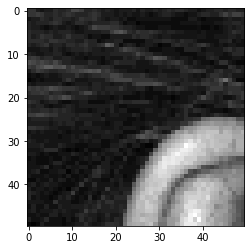

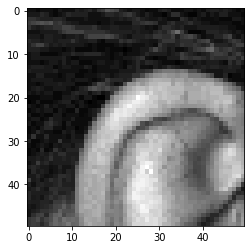

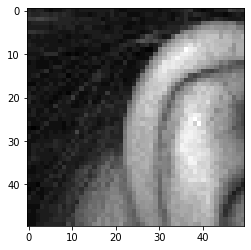

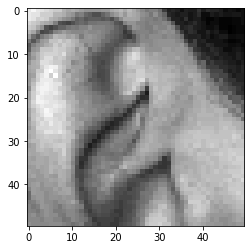

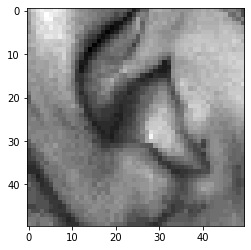

In [13]:
fetch_extracted_window(chosen_sw)